In [10]:
import numpy as np
import math
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix, coo_matrix, issparse, eye
from scipy.sparse.linalg import eigsh, eigs
from scipy.special import factorial
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
import itertools
from collections import defaultdict
from functools import lru_cache
#from quspin.basis import spin_basis_1d, spin_basis_general
#import tenpy as tp

In [11]:
# ---- spin-1 single-site ops ----
def spin1_operators(dtype=np.complex128):
    Sx = (1/np.sqrt(2)) * np.array([[0, 1, 0],
                                    [1, 0, 1],
                                    [0, 1, 0]], dtype=dtype)
    Sy = (1/np.sqrt(2)) * np.array([[0, -1j, 0],
                                    [1j,  0, -1j],
                                    [0,  1j, 0]], dtype=dtype)
    Sz = np.array([[ 1, 0, 0],
                   [ 0, 0, 0],
                   [ 0, 0,-1]], dtype=dtype)
    return Sx, Sy, Sz

# ---- embeddings ----
def embed_one(L, site, A, d, dtype=np.complex128):
    I = eye(d, dtype=dtype, format='csr')
    op = None
    for s in range(L):
        factor = csr_matrix(A) if s == site else I
        op = factor if op is None else kron(op, factor, format='csr')
    return op

def embed_two(L, i, j, A, B, d, dtype=np.complex128):
    # Handle case where i > j (e.g., periodic boundary wrapping)
    if i > j:
        i, j = j, i
        A, B = B, A
    assert 0 <= i < j < L
    I = eye(d, dtype=dtype, format='csr')
    op = None
    for s in range(L):
        if s == i:   factor = csr_matrix(A)
        elif s == j: factor = csr_matrix(B)
        else:        factor = I
        op = factor if op is None else kron(op, factor, format='csr')
    return op

# ---- H = H_XY + h∑Sz + D∑Sz^2 + J3∑ (3rd-nn XY) ----
def hamiltonian_spin1_xy_plus_H3(L, J=1.0, h=0.0, D=0.0, J3=0.0, bc='open', dtype=np.complex128):
    d = 3
    Sx, Sy, Sz = spin1_operators(dtype=dtype)
    H = csr_matrix((d**L, d**L), dtype=dtype)

    # NN XY
    nn_pairs = [(i, i+1) for i in range(L-1)]
    if bc == 'periodic' and L > 1:
        nn_pairs.append((L-1, 0))
    for i, j in nn_pairs:
        H += J * embed_two(L, i, j, Sx, Sx, d=d, dtype=dtype)
        H += J * embed_two(L, i, j, Sy, Sy, d=d, dtype=dtype)

    # 3rd-NN XY
    if J3 != 0.0 and L >= 4:
        if bc == 'open':
            pairs3 = [(i, i+3) for i in range(L-3)]
        elif bc == 'periodic':
            pairs3 = [(i, (i+3) % L) for i in range(L)]
        else:
            raise ValueError("bc must be 'open' or 'periodic'")
        for i, j in pairs3:
            H += J3 * embed_two(L, i, j, Sx, Sx, d=d, dtype=dtype)
            H += J3 * embed_two(L, i, j, Sy, Sy, d=d, dtype=dtype)

    # Onsite h and D
    if h != 0.0 or D != 0.0:
        Sz_loc = Sz
        Sz2_loc = Sz @ Sz
        for i in range(L):
            if h != 0.0:
                H += h * embed_one(L, i, Sz_loc, d=d, dtype=dtype)
            if D != 0.0:
                H += D * embed_one(L, i, Sz2_loc, d=d, dtype=dtype)

    return H

# ---- Symmetry generators ----
def total_Sz(L, dtype=np.complex128):
    _, _, Sz = spin1_operators(dtype=dtype)
    d = 3
    Sztot = csr_matrix((d**L, d**L), dtype=dtype)
    for i in range(L):
        Sztot += embed_one(L, i, Sz, d=d, dtype=dtype)
    return Sztot

def inversion_operator(L, d=3, dtype=np.complex128):
    """
    Spatial inversion P that reverses site order: (s0,s1,...,s_{L-1}) -> (s_{L-1},...,s0)
    Acts on the product basis of dimension d^L as a permutation matrix.
    """
    dim = d**L
    rows, cols = np.arange(dim), np.empty(dim, dtype=np.int64)

    # helper: base-d digits of n with length L
    def to_digits(n):
        ds = []
        for _ in range(L):
            ds.append(n % d)
            n //= d
        return ds  # little-endian (site 0 in index 0)

    def from_digits(ds):
        n = 0
        for k in reversed(range(L)):  # inverse of to_digits
            n = n * d + ds[k]
        return n

    for n in range(dim):
        ds = to_digits(n)          # [s0, s1, ..., s_{L-1}]
        ds_rev = ds[::-1]          # reverse sites
        m = from_digits(ds_rev)
        cols[n] = m

    data = np.ones(dim, dtype=dtype)
    return csr_matrix((data, (rows, cols)), shape=(dim, dim), dtype=dtype)

# ---- Commutator utility ----
def commutator(A, B):
    return A @ B - B @ A

def sparse_max_abs(M):
    if M.nnz == 0:
        return 0.0
    return np.max(np.abs(M.data))

# ---- Top-level check ----
def check_symmetries(L, J=1.0, h=0.0, D=0.0, J3=0.0, bc='open', tol=1e-12, verbose=True):
    H = hamiltonian_spin1_xy_plus_H3(L, J, h, D, J3, bc)
    P = inversion_operator(L, d=3)
    Sz_tot = total_Sz(L)

    c_inv = commutator(H, P)
    c_sz  = commutator(H, Sz_tot)

    max_inv = sparse_max_abs(c_inv)
    max_sz  = sparse_max_abs(c_sz)

    ok_inv = max_inv < tol
    ok_sz  = max_sz  < tol

    if verbose:
        print(f"[H, P]  max|.| = {max_inv:.3e}  -> {'OK' if ok_inv else 'NOT ZERO'}")
        print(f"[H, Sz] max|.| = {max_sz:.3e}  -> {'OK' if ok_sz else 'NOT ZERO'}")

    return ok_inv, ok_sz, max_inv, max_sz

# ---- Example usage (small L due to 3^L growth) ----
ok_inv, ok_sz, max_inv, max_sz = check_symmetries(L=6, J=1.0, h=0.2, D=0.5, J3=0.3, bc='open')
ok_inv, ok_sz, max_inv, max_sz = check_symmetries(L=7, J=1.0, h=0.0, D=0.0, J3=0.0, bc='periodic')


[H, P]  max|.| = 8.882e-16  -> OK
[H, Sz] max|.| = 0.000e+00  -> OK
[H, P]  max|.| = 0.000e+00  -> OK
[H, Sz] max|.| = 0.000e+00  -> OK


In [ ]:
# ----- Lin-style additive tables for spin-1 (alphabet = [-1, 0, +1]) -----

class CountTable:
    """
    DP table: ways(n, r) = number of length-n strings over {-1,0,1} summing to r.
    Gives O(1) access after memoization, and helpers to rank/unrank in O(L).
    """
    __slots__ = ("L", "alphabet")
    def __init__(self, L, alphabet=(-1,0,1)):
        self.L = L
        self.alphabet = tuple(sorted(alphabet))  # must be sorted for lexicographic ranking

    @lru_cache(maxsize=None)
    def ways(self, n, r):
        # number of strings of length n with sum r
        if n == 0:
            return 1 if r == 0 else 0
        total = 0
        for a in self.alphabet:
            total += self.ways(n-1, r-a)
        return total

def rank_in_m(cfg, m, tab: CountTable):
    """
    Lexicographic rank of cfg among all length-L strings with sum m.
    cfg entries must be in tab.alphabet; returns 0-based rank.
    """
    L = tab.L
    assert len(cfg) == L
    rem = m
    rank = 0
    for i, x in enumerate(cfg):
        nleft = L - i - 1
        # count all sequences starting with smaller symbols than x
        for a in tab.alphabet:
            if a >= x:
                break
            rank += tab.ways(nleft, rem - a)
        rem -= x
    # optional: assert rem == 0
    return rank

def unrank_in_m(rank, m, tab: CountTable):
    """
    Inverse of rank_in_m: return cfg with given rank in the m-sector.
    """
    L = tab.L
    cfg = []
    rem = m
    r = rank
    for i in range(L):
        nleft = L - i - 1
        # choose smallest a such that cumulative ways exceeds r
        cum = 0
        for a in tab.alphabet:
            w = tab.ways(nleft, rem - a)
            if r < cum + w:
                cfg.append(a)
                rem -= a
                r -= cum
                break
            cum += w
        else:
            raise ValueError("unrank failed: out of range")
    return tuple(cfg)

def iter_states_m(L, m, tab: CountTable):
    """
    Generate the m-sector in lexicographic order using DP pruning.
    """
    stack = [([], 0, m)]  # (prefix, i, remaining sum)
    A = tab.alphabet
    while stack:
        pref, i, rem = stack.pop()
        if i == L:
            if rem == 0:
                yield tuple(pref)
            continue
        nleft = L - i - 1
        # push in reverse order to pop smallest first (lexicographic ascending)
        for a in reversed(A):
            if tab.ways(nleft, rem - a) > 0:
                stack.append((pref + [a], i+1, rem - a))

def invert_cfg(cfg):
    return tuple(cfg[::-1])

def perm_index_inversion(idx, m, tab: CountTable):
    """
    Given index idx in the m-sector, return the index of the inverted configuration.
    """
    cfg = unrank_in_m(idx, m, tab)
    icfg = invert_cfg(cfg)
    return rank_in_m(icfg, m, tab)

# ----- Spin-1 XY(+onsite + third-NN) in the m-sector using ranks only -----

def sp_factor(mval):
    # S=1 ladder factor <m+1|S^+|m> for m in {-1,0}
    if mval >= 1: return 0.0
    S = 1.0
    return np.sqrt(S*(S+1) - mval*(mval+1))

def sm_factor(mval):
    # S=1 ladder factor <m-1|S^-|m> for m in {0,+1}
    if mval <= -1: return 0.0
    S = 1.0
    return np.sqrt(S*(S+1) - mval*(mval-1))

def build_H_sector(L, m, J=1.0, h=0.0, D=0.0, J3=0.0, bc='open'):
    """
    Build H restricted to total Sz = m using Lin-style tables for indexing.
    Returns sparse CSR of shape (Nm, Nm), where Nm = ways(L, m).
    """
    tab = CountTable(L)
    Nm = tab.ways(L, m)
    rows, cols, data = [], [], []

    # Bonds
    nn = [(i, i+1) for i in range(L-1)]
    bonds3 = [(i, i+3) for i in range(L-3)] if L >= 4 else []
    if bc == 'periodic':
        nn.append((L-1, 0))
        bonds3 = [(i, (i+3) % L) for i in range(L)]

    # Iterate states without Python sets:
    for idx, cfg in enumerate(iter_states_m(L, m, tab)):
        cfg = list(cfg)

        # onsite diagonal
        diag = h * sum(cfg) + D * sum(x*x for x in cfg) if (h or D) else 0.0
        if diag:
            rows.append(idx); cols.append(idx); data.append(diag)

        def xy_pair(i, j, Jval):
            # (J/2) (S^+_i S^-_j + S^-_i S^+_j)
            mi, mj = cfg[i], cfg[j]

            if mi < +1 and mj > -1:
                amp = 0.5 * Jval * sp_factor(mi) * sm_factor(mj)
                if amp:
                    new = cfg[:]
                    new[i] = mi + 1; new[j] = mj - 1
                    jdx = rank_in_m(tuple(new), m, tab)
                    rows.append(idx); cols.append(jdx); data.append(amp)

            if mi > -1 and mj < +1:
                amp = 0.5 * Jval * sm_factor(mi) * sp_factor(mj)
                if amp:
                    new = cfg[:]
                    new[i] = mi - 1; new[j] = mj + 1
                    jdx = rank_in_m(tuple(new), m, tab)
                    rows.append(idx); cols.append(jdx); data.append(amp)

        if J:
            for (i, j) in nn:
                xy_pair(i, j, J)
        if J3:
            for (i, j) in bonds3:
                xy_pair(i, j, J3)

    Hm = coo_matrix((data, (rows, cols)), shape=(Nm, Nm))
    # Ensure Hermiticity numerically (optional symmetrization for safety):
    Hm = 0.5 * (Hm + Hm.getH())
    return Hm.tocsr(), tab

# ----- Inversion-odd projector using only ranks -----

def inversion_odd_projector(L, m, tab: CountTable):
    """
    Build rectangular Q whose columns are normalized odd combinations:
    Q[:,k] = (|i> - |P i>)/sqrt(2), with i < P(i), excluding palindromes.
    """
    Nm = tab.ways(L, m)
    # Find representatives (i < P(i), not palindromic)
    reps = []
    visited = np.zeros(Nm, dtype=bool)
    for i in range(Nm):
        if visited[i]: continue
        j = perm_index_inversion(i, m, tab)
        if j == i:
            visited[i] = True  # palindrome -> contributes only to even sector
            continue
        i0, j0 = (i, j) if i < j else (j, i)
        reps.append(i0)
        visited[i0] = True
        visited[j0] = True

    Nodd = len(reps)
    rows = []
    cols = []
    data = []
    invsqrt2 = 1.0 / np.sqrt(2.0)
    for col, i in enumerate(reps):
        j = perm_index_inversion(i, m, tab)
        rows.extend([i, j])
        cols.extend([col, col])
        data.extend([invsqrt2, -invsqrt2])

    Q = coo_matrix((data, (rows, cols)), shape=(Nm, Nodd)).tocsr()
    return Q, Nodd

# ----- Example: L=16, m=-10, OBC, diagonalize few lowest in I = -1 -----

L, m = 16, -10
J, h, D, J3 = 1.0, 0.0, 0.0, 0.0
Hm, tab = build_H_sector(L, m, J=J, h=h, D=D, J3=J3, bc='open')

# Build odd inversion projector (OBC inversion = reverse sites)
Q, Nodd = inversion_odd_projector(L, m, tab)
print(f"dim(H_m) = {tab.ways(L, m)},   dim(I=-1) = {Nodd}")  # 41328, 20608

H_odd = (Q.T @ Hm @ Q).tocsr()

dim(H_m) = 41328,   dim(I=-1) = 20608
Lowest eigenvalues (I=-1, m=-10):
0: -9.965768453865
1: -9.576640081846
2: -9.491565002959
3: -9.422917531735
4: -9.342707336032
5: -9.174747390050


In [5]:
# ---------- Diagonalize few lowest eigenpairs ----------
# H is real-symmetric; use sigma=None for smallest algebraic by default.
# If you want *lowest energy* and the spectrum can be negative, use which='SA'.
eigs, vecs = eigsh(H_odd, k=1, which='SA')
eigs.sort()
print("Lowest eigenvalues in (m=-10, I=-1):")
for i, ev in enumerate(eigs):
    print(f"{i}: {ev:.12f}")

Lowest eigenvalues in (m=-10, I=-1):
0: -9.965768453865


In [6]:
# spin-1 basis states + spin operators

# basis states for spin-1 system
# |1> state
ket_p1 = csr_matrix([[1], [0], [0]])

# |0> state
ket_0 = csr_matrix([[0], [1], [0]])

# |-1> state
ket_m1 = csr_matrix([[0], [0], [1]])

# Spin-1 operators as sparse matrices
Sx = 1 / np.sqrt(2) * csr_matrix([[0, 1, 0],
                                    [1, 0, 1],
                                    [0, 1, 0]], dtype=np.complex128)
Sy = 1 / np.sqrt(2) * csr_matrix([[0, -1j, 0],
                                    [1j, 0, -1j],
                                    [0, 1j, 0]], dtype=np.complex128)
Sz = csr_matrix([[1, 0, 0],
                    [0, 0, 0],
                    [0, 0, -1]], dtype=np.complex128)

I = identity(3, format='csr', dtype=np.complex128)

# S_+ operator
Sp = Sx + 1j * Sy

# S_- operator
Sm = Sx - 1j * Sy

# --- Vacuum state |omega> = |-1>^{⊗L} ---
def omega(L):
    state = ket_m1
    for _ in range(L-1):
        state = kron(state, ket_m1, format='csr')
    return state

# --- S^+ at site k (1-based), identity elsewhere ---
def S_plus_at_site(k, L):
    op = 1
    for site in range(1, L+1):
        if site == k:
            op = kron(op, Sp, format='csr')
        else:
            op = kron(op, identity(3, format='csr'), format='csr')
    return op

# --- J^+ operator ---
def J_plus(L):
    Jp = csr_matrix((3**L, 3**L), dtype=complex)
    for k in range(1, L+1):
        phase = np.exp(1j * np.pi * k)
        Splus2 = S_plus_at_site(k, L).dot(S_plus_at_site(k, L))
        Jp += phase * Splus2
    Jp *= 0.5
    return Jp

# --- Tower state |n> ---
def tower_state(n, L):
    norm = np.sqrt(factorial(L-n) / (factorial(n) * factorial(L)))
    Jp = J_plus(L)
    psi = omega(L)
    for _ in range(n):
        psi = Jp.dot(psi)
    return norm * psi

# Construct S^+_i S^+_{i+1} operator
def bond_bimagnon_op(i, L):
    op = 1
    for site in range(L):
        if site == i:
            op_site = Sp
        elif site == (i + 1) % L:
            op_site = Sp
        else:
            op_site = I
        op = kron(op, op_site, format='csr')
    return op

def other_tower_state(n, L):
    psi = csr_matrix((3**L, 1))
    vac = omega(L)
    
    # all combinations of n distinct bond positions (allow overlap if desired)
    bond_sites = combinations(range(L), n)
    
    for sites in bond_sites:
        sign = (-1) ** sum(sites)
        op = identity(3**L, format='csr')
        for i in sites:
            op = op @ bond_bimagnon_op(i, L)
        psi += sign * (op @ vac)

    # Normalize
    norm = np.sqrt(psi.getH().dot(psi).toarray()[0, 0])
    return psi / norm if norm > 0 else psi

In [7]:
# functions

def innermost_adjacent_indices(L, block_size):
    """
    Returns the indices of the innermost adjacent block of given size.
    For even L, the block is centered in the middle.
    """
    start = (L - block_size) // 2
    return list(range(start, start + block_size))

def all_adjacent_indices(L, block_size, bc):
    """
    Returns a list of all possible adjacent blocks of given size.
    Each block is represented as a list of indices.
    
    Args:
        L: system size  
        block_size: size of the block
        bc: boundary conditions ('obc' or 'pbc')
    """
    blocks = []
    
    if bc == 'obc':
        # Original OBC implementation
        for start in range(L - block_size + 1):
            blocks.append(list(range(start, start + block_size)))
    
    elif bc == 'pbc':
        # PBC implementation - sites wrap around
        for start in range(L):
            block = []
            for i in range(block_size):
                block.append((start + i) % L)  # Wrap around using modulo
            blocks.append(block)
    
    else:
        raise ValueError("Boundary condition must be 'obc' or 'pbc'")
    
    return blocks

def ptrace_sparse(dm_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        dm_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    

    dm_sparse = dm_sparse.tocoo()

    for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)

    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ptrace_sparse_parallel(dm_sparse, keep, dims, n_jobs=-1): # njobs to be removed if not using joblib
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.
    Parallelized over nonzero elements.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])


    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    
    dm_sparse = dm_sparse.tocoo()

    def process_entry(i,j,val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry)(i, j, val)
        for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data))
    )
    results = [r for r in results if r is not None]

    '''entries = zip(psi_sparse.row, psi_sparse.col, psi_sparse.data)
    results = []
    with ThreadPoolExecutor() as executor:
        for res in executor.map(process_entry, entries):
            if res is not None:
                results.append(res)'''
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ee_sparse(dm_sparse, L):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse(dm_sparse, list(range(L // 2)), [3] * L)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def ee_sparse_parallel(dm_sparse, L, n_jobs=-1):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse_parallel(dm_sparse, list(range(L // 2)), [3] * L, n_jobs=n_jobs)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def rdm_qutip(state, L, keep_qubits):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[3] * L, [3] * L])
    rdm = ptrace(rho_qobj, keep_qubits)
    rdm_mat = rdm.full()
    eigvals = np.linalg.eigvalsh(rdm_mat)
    min_eigval = np.min(eigvals)
    # Rank: count nonzero eigenvalues (with tolerance)
    rank = np.sum(eigvals > 1e-12)
    return rdm, min_eigval, rank

def ee_qutip(state, L):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[3] * L, [3] * L])
    rhoA = ptrace(rho_qobj, list(range(L//2)))
    return entropy_vn(rhoA)

In [8]:
L = 10 # number of sites -  it has to be even
bc = 'pbc'  # boundary condition, can be 'obc' or 'pbc'

innermost_2 = innermost_adjacent_indices(L, 2)
innermost_3 = innermost_adjacent_indices(L, 3)
innermost_4 = innermost_adjacent_indices(L, 4)

adjacent_2 = all_adjacent_indices(L, 2, bc)
adjacent_3 = all_adjacent_indices(L, 3, bc)
adjacent_4 = all_adjacent_indices(L, 4, bc)

print("All adjacent 2-site blocks:", adjacent_2)
print("All adjacent 3-site blocks:", adjacent_3)
print("All adjacent 4-site blocks:", adjacent_4)


All adjacent 2-site blocks: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 0]]
All adjacent 3-site blocks: [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9, 0], [9, 0, 1]]
All adjacent 4-site blocks: [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 0], [8, 9, 0, 1], [9, 0, 1, 2]]


In [9]:
# SPIN-1 XY - PRL 147201

scar_state = other_tower_state(5, L)
#dimer_state = dimer_state.flatten()  # Reshape to column vector
print(f"scar state dimension for L={L}: {scar_state.shape}")

# Print number of zero components (with tolerance 1e-12)
#print(np.count_nonzero(scar_state))
num_zeros = np.sum(np.abs(scar_state) > 1e-16)
print(f"Number of zero components in dimer_state (tol=1e-12): {num_zeros}")

scar_sparse = csr_matrix(scar_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
print("Number of zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [3]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")
'''rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [3]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'''

NameError: name 'combinations' is not defined

In [ ]:
# MG + CS - PRL 147201

'''
# L is your system size
# Nup = L//2 for Sz=0 sector (number of up spins)
# kblock=0 for momentum k=0 (T=1 eigenvalue)
sym_basis = spin_basis_1d(L, Nup=L//2, kblock=0)
print("Basis size:", sym_basis.Ns)

# get symmetry basis states as integers
proj_states = sym_basis.get_proj(np.arange(sym_basis.Ns))

# project dimer_state onto the symmetry sector
xy_proj = scar_state[proj_states]

# normalize if desired
xy_proj = xy_proj / np.linalg.norm(xy_proj)


# xy_proj is now the state in the (Sz=0, T=1) sector basis
'''


# xy ee for single L and Ltar dependence
#xy_scar_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
#print(f"xy-scar entanglement entropy for L={L}: {xy_scar_ee}")

Ltar = np.asarray([8, 10, 12, 14])
scar_states = [other_tower_state(Lt//2, Lt) for Lt in tqdm(Ltar)]

print(len(scar_states))

# Convert each state vector to density matrix before computing entanglement entropy
scar_density_matrices = []
for i, state in enumerate(scar_states):
    scar_sparse = csr_matrix(state.reshape(-1, 1))  # Convert to sparse column vector
    dm_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
    scar_density_matrices.append(dm_sparse)

print(len(scar_density_matrices))

# Compute RDMs and their ranks for each system size
xy_scar_2_tar = []
xy_scar_3_tar = []
xy_scar_4_tar = []

for i, Lt in tqdm(enumerate(Ltar)):
    # Compute RDMs
    rdm_2 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_2, [3]*Lt, n_jobs=-1)
    rdm_3 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_3, [3]*Lt, n_jobs=-1)
    rdm_4 = ptrace_sparse_parallel(scar_density_matrices[i], innermost_4, [3]*Lt, n_jobs=-1)
    
    # Compute ranks and append to lists
    xy_scar_2_tar.append(np.linalg.matrix_rank(rdm_2.toarray()))
    xy_scar_3_tar.append(np.linalg.matrix_rank(rdm_3.toarray()))
    xy_scar_4_tar.append(np.linalg.matrix_rank(rdm_4.toarray()))

100%|██████████| 4/4 [1:19:13<00:00, 1188.35s/it]


4
4


4761it [00:01, 3104.43it/s]
4761it [00:00, 21484.12it/s]
4761it [00:00, 22864.95it/s]
62500it [00:00, 104228.60it/s]
62500it [00:00, 92913.59it/s]
62500it [00:00, 95848.53it/s] 
851929it [00:08, 105094.04it/s]
851929it [00:08, 103367.58it/s]
851929it [00:08, 103106.34it/s]
11764900it [02:00, 97386.02it/s]
11764900it [02:00, 97468.04it/s] 
11764900it [01:59, 98795.06it/s] 
4it [06:32, 98.24s/it] 


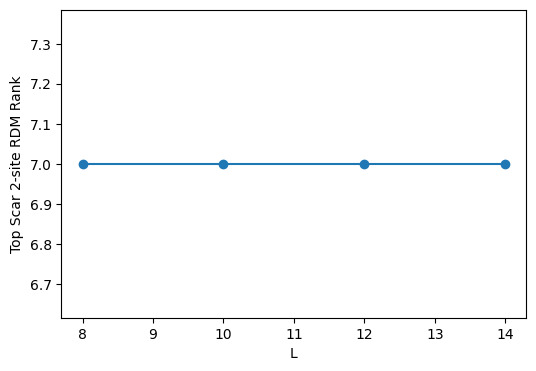

In [ ]:
# 2 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, xy_scar_2_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 2-site RDM Rank')
#plt.title('XY S=1 2-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('xy_scar_2p.png', dpi=300, bbox_inches='tight')
plt.show()

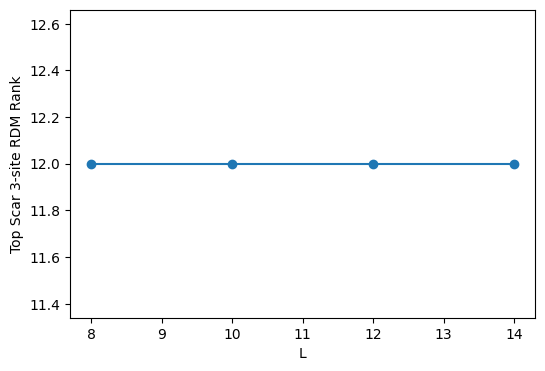

In [ ]:
# 3 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, xy_scar_3_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 3-site RDM Rank')
#plt.title('XY S=1 3-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('xy_scar_3p.png', dpi=300, bbox_inches='tight')
plt.show()

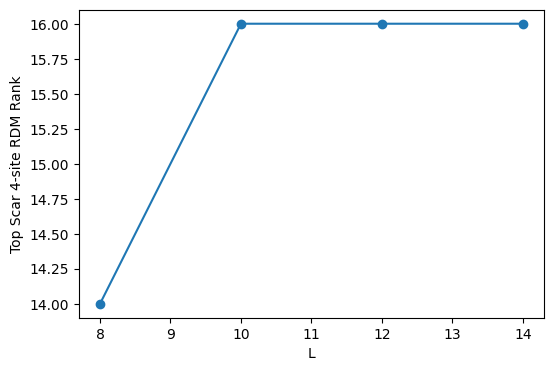

In [ ]:
# 4 sites rdm rank

plt.figure(figsize=(6,4))
plt.plot(Ltar, xy_scar_4_tar, marker='o')
plt.xlabel('L')
plt.ylabel('Top Scar 4-site RDM Rank')
#plt.title('XY S=1 4-sites RDM Rank vs L')
#plt.grid(True)
plt.savefig('xy_scar_4p.png', dpi=300, bbox_inches='tight')
plt.show()